In [1]:
# Direct Preference Optimization: Your Language Model is Secretly a Reward Model
# https://arxiv.org/abs/2305.18290

In [3]:
from functools import partial
import os
import tiktoken
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoModelForCausalLM

from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "False"

$$
\mathcal{L}_{\mathrm{DPO}}\left(\pi_\theta ; \pi_{\mathrm{ref}}\right)=-\mathbb{E}_{\left(x, y_w, y_l\right) \sim \mathcal{D}}\left[\log \sigma\left(\beta \log \frac{\pi_\theta\left(y_w \mid x\right)}{\pi_{\mathrm{ref}}\left(y_w \mid x\right)}-\beta \log \frac{\pi_\theta\left(y_l \mid x\right)}{\pi_{\mathrm{ref}}\left(y_l \mid x\right)}\right)\right]
$$

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
dataset = load_dataset("jondurbin/py-dpo-v0.1", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

py-dpo.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9466 [00:00<?, ? examples/s]

In [7]:
dataset = dataset.train_test_split(test_size=0.1, seed=42)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'id'],
        num_rows: 8519
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'id'],
        num_rows: 947
    })
})

In [9]:
print("Prompt: ")
print("====================================")
print(dataset["train"][0]["prompt"])
print("\n\nChosen: ")
print("====================================")
print(dataset["train"][0]["chosen"])
print("\n\nRejected: ")
print("====================================")
print(dataset["train"][0]["rejected"])

Prompt: 
What are some efficient algorithms in Python for finding the intersection between two sets of geographic coordinates within a given radius?


Chosen: 
One possible algorithm for finding the intersection between two sets of geographic coordinates within a given radius in Python is as follows:

1. Define a function that calculates the great circle distance between two points on the Earth's surface. This can be done using the Haversine formula, which takes into account the Earth's radius and the latitude and longitude of the two points.

2. Define a function that takes two sets of geographic coordinates (as lists of latitude and longitude pairs) and a radius as input, and returns the intersection between the two sets within the given radius. This can be done by looping over all pairs of points from the two sets and checking whether the great circle distance between them is less than the given radius. If so, add the pair to a list of intersecting points.

3. Use this function to f

In [10]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['prompt']}"
    )
    return instruction_text

In [11]:
tokenizer = tiktoken.get_encoding("gpt2")

In [12]:
def tokenize_fn(entry: dict):

    prompt = format_input(entry)
    chosen_response = entry["chosen"]
    rejected_response = entry["rejected"]

    chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
    rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"

    prompt_tokens = tokenizer.encode(chosen_full_text)
    chosen_full_tokens = tokenizer.encode(chosen_full_text)
    rejected_full_tokens = tokenizer.encode(rejected_full_text)

    return { "prompt": prompt_tokens, "chosen": chosen_full_tokens, "rejected": rejected_full_tokens }

In [13]:
train_data = dataset["train"].to_list()
test_data = dataset["test"].to_list()

In [14]:
class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.tokenized_data = []
        for entry in data:
            self.tokenized_data.append(tokenizer(entry))

    def __getitem__(self, index):
        return self.tokenized_data[index]

    def __len__(self):
        return len(self.tokenized_data)

In [15]:
train_dataset = PreferenceDataset(train_data, tokenize_fn)
test_dataset = PreferenceDataset(test_data, tokenize_fn)

In [16]:
print("Prompt: ")
print("====================================")
print(train_dataset[0]["prompt"])
print("\nChosen: ")
print("====================================")
print(train_dataset[0]["chosen"])
print("\nRejected: ")
print("====================================")
print(train_dataset[0]["rejected"])

Prompt: 
[21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 2061, 389, 617, 6942, 16113, 287, 11361, 329, 4917, 262, 16246, 1022, 734, 5621, 286, 22987, 22715, 1626, 257, 1813, 16874, 30, 198, 198, 21017, 18261, 25, 198, 3198, 1744, 11862, 329, 4917, 262, 16246, 1022, 734, 5621, 286, 22987, 22715, 1626, 257, 1813, 16874, 287, 11361, 318, 355, 5679, 25, 198, 198, 16, 13, 2896, 500, 257, 2163, 326, 43707, 262, 1049, 9197, 5253, 1022, 734, 2173, 319, 262, 3668, 338, 4417, 13, 770, 460, 307, 1760, 1262, 262, 9398, 690, 500, 10451, 11, 543, 2753, 656, 1848, 262, 3668, 338, 16874, 290, 262, 32477, 290, 890, 3984, 286, 262, 734, 2173, 13, 198, 198, 17, 13, 2896, 500, 257, 2163, 326, 2753, 734, 5621, 286, 22987, 22715, 357, 292, 8341, 286, 32477, 290, 890, 3984, 14729, 8, 290, 257, 16874, 355, 5128, 11, 290, 5860, 262, 16246, 1022, 262, 734, 5621, 1626, 262, 1813, 16874, 13, 770, 460, 307, 1760, 416, 9052, 278

In [17]:
def collate_fn(
    batch,
    pad_token_id = 50256,
    context_length = None,
    mask_prompt_tokens = True,
    device = "cpu",
):

    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [], # padding mask
        "chosen_mask": [] # padding mask
    }

    # dynamic padding
    max_length_common = 0
    for key in ["chosen", "rejected"]:
        current_max = max(len(item[key])+1 for item in batch)
        max_length_common = max(max_length_common, current_max)

    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:

            # adjust padding according to the common maximum length
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool()

            # print(f"Sequence {key}: {sequence}")
            # print(f"Length: {len(sequence)}")
            # print(f"Max Length: {max_length_common}")
            # print(f"Padded: {padded}")
            # print(f"Mask: {mask}")

            # set mask for padding tokens
            mask[len(sequence):] = False

            # print(f"Mask after padding token: {mask}")

            # set mask for all prompt tokens to false
            # +2 sets the 2 newline ("\n") tokens before "### Response" to false
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False
                # print(f"Mask prompt tokens size: {prompt.shape[0]+2}")
                # print(f"Mask prompt tokens after: {mask}")
                # print(f"Mask prompt tokens any true: {mask.any()}")


            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # stack all sequences into a tensor for the given key
        tensor_stack = torch.stack(batch_data[key])

        # truncate to maximum sequence length
        if context_length is not None:
            tensor_stack = tensor_stack[:, :context_length]

        batch_data[key] = tensor_stack.to("cpu") # avoid RuntimeError: Cannot re-initialize CUDA in forked subprocess.

    return batch_data

In [18]:
custom_collate_fn = partial(
    collate_fn,
    device=device,
    mask_prompt_tokens=False,
    context_length=1024
)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn, num_workers=1)
test_loader = DataLoader(test_dataset,batch_size=8, collate_fn=custom_collate_fn, num_workers=1)

In [20]:
for batch in train_loader:
    break

In [21]:
print("Train loader:")
for idx, batch in enumerate(train_loader):
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )
    if idx>10:
        break

print("\nTest loader:")
for idx, batch in enumerate(test_loader):
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )
    if idx>10:
        break

Train loader:
torch.Size([8, 809]) torch.Size([8, 809])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 754]) torch.Size([8, 754])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 937]) torch.Size([8, 937])

Test loader:
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 840]) torch.Size([8, 840])
torch.Size([8, 1012]) torch.Size([8, 1012])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 966]) torch.Size([8, 966])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 994]) torch.Size([8, 994])
torch.Size([8, 781]) torch.Size([8, 781])
torch.Size([8, 102

## DPO training

$$
\mathcal{L}_{\mathrm{DPO}}\left(\pi_\theta ; \pi_{\mathrm{ref}}\right)=-\mathbb{E}_{\left(x, y_w, y_l\right) \sim \mathcal{D}}\left[\log \sigma\left(\beta \log \frac{\pi_\theta\left(y_w \mid x\right)}{\pi_{\mathrm{ref}}\left(y_w \mid x\right)}-\beta \log \frac{\pi_\theta\left(y_l \mid x\right)}{\pi_{\mathrm{ref}}\left(y_l \mid x\right)}\right)\right]
$$

where,
- $\pi_\theta$ policy model (LLM to optimize)
- $ \pi_{\mathrm{ref}}$ reference model (original LLM before optimization)
- $\mathbb{E}$ is expected value
- $\sigma$ logistic sigmoid function
- $\beta$ hyperparameter to control the divergence between the $\pi_{\theta}$ and $\pi_{ref}$

In [22]:
policy_model = AutoModelForCausalLM.from_pretrained("gpt2")
reference_model = AutoModelForCausalLM.from_pretrained("gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
policy_model.to(device)
reference_model.to(device)

In [24]:
def compute_logprobs(
    logits, # (batch_size, num_tokens, vocab_size)
    labels, # (batch_size, num_tokens)
    selection_mask=None # (batch_size, num_tokens)
):

    # print(f"Labels: {labels}")
    # print(f"Labels shape: {labels.shape}")

    # labels are the inputs shifted by one
    #   i.e. the model predicts the next token in the sequence,
    #   so the labels are the input tokens shifted to the left
    #   and the first token is ignored (because there's no previous token to predict)
    labels = labels[:, 1:].clone()

    # adjust logits to match the labels num_tokens
    #   i.e. truncate the logits by removing the last token's logits
    #   because there's no corresponding target (label) to predict for the last token.
    if isinstance(logits, CausalLMOutputWithCrossAttentions): # transformers returns CausalLMOutputWithCrossAttentions class, workaround to get logits
        logits = logits.logits

    # print(f"Logits: {logits}")
    # print(f"Logits shape: {logits.shape}")

    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # select log probability the model assigned to the correct token at each position
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    # print("Log probs:", selected_log_probs)
    # print("Log probs shape:", selected_log_probs.shape)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # print("Mask:", mask)
        # print("Mask shape:", mask.shape)

        # apply the mask to filter out padding tokens
        #    i.e. set the log probabilities of padding tokens to 0
        selected_log_probs = selected_log_probs * mask

        # print("selected log probs:", selected_log_probs)
        # print("selected log probs shape:", selected_log_probs.shape)

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size, num_tokens)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1) # divide by number of real tokens

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

In [25]:
def compute_dpo_loss(
      model_chosen_logprobs,
      model_rejected_logprobs,
      reference_chosen_logprobs,
      reference_rejected_logprobs,
      beta=0.1,
    ):

    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    losses = -F.logsigmoid(beta * logits)

    # track progress during training
    # reward ~ how much better the policy model is than the reference model
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

In [26]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):


    batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

    # print("policy model device: ", policy_model.device)
    # print("reference model device: ", reference_model.device)
    # print("batch chose device: ", batch["chosen"].device)
    # print("batch rejected device: ", batch["rejected"].device)

    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )

    with torch.no_grad():
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

In [27]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss)

(tensor(0.6931, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


In [28]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):

    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.

    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # calculate average
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches

    return total_loss, total_chosen_rewards, total_rejected_rewards

In [29]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):

    policy_model.eval()
    with torch.no_grad():

        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

In [30]:
def train_model_dpo(
    policy_model,
    reference_model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs,
    beta,
    eval_freq,
    eval_iter
):

    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        policy_model.train()

        for batch_idx, batch in enumerate(train_loader):

            optimizer.zero_grad()  # reset loss gradients from previous batch iteration

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # calculate loss gradients
            optimizer.step()  # update model weights using loss gradients

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # evaluation step
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)

                # rewared margin ~ how much more the policy model "prefers" the preferred answer
                #                  compared to the rejected one, relative to the reference model.
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )
    return tracking

In [31]:
import time

start_time = time.time()

optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.5,
    eval_freq=5,
    eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.691, Val loss 0.692, Train reward margins 0.008, Val reward margins 0.005
Ep 1 (Step 000005): Train loss 0.687, Val loss 0.688, Train reward margins 0.026, Val reward margins 0.021
Ep 1 (Step 000010): Train loss 0.682, Val loss 0.684, Train reward margins 0.046, Val reward margins 0.035
Ep 1 (Step 000015): Train loss 0.677, Val loss 0.681, Train reward margins 0.066, Val reward margins 0.048
Ep 1 (Step 000020): Train loss 0.672, Val loss 0.679, Train reward margins 0.090, Val reward margins 0.058
Ep 1 (Step 000025): Train loss 0.668, Val loss 0.677, Train reward margins 0.105, Val reward margins 0.067
Ep 1 (Step 000030): Train loss 0.669, Val loss 0.676, Train reward margins 0.102, Val reward margins 0.074
Ep 1 (Step 000035): Train loss 0.662, Val loss 0.675, Train reward margins 0.134, Val reward margins 0.076
Ep 1 (Step 000040): Train loss 0.641, Val loss 0.675, Train reward margins 0.223, Val reward margins 0.078
Ep 1 (Step 000045): Train loss 0.659,

In [33]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # plot training and validation loss (or reward margins) against epochs
    ax1.plot(epochs_seen, train_losses, label=f"Training {label}")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # second x-axis for tokens seen
    ax2 = ax1.twiny()  # second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


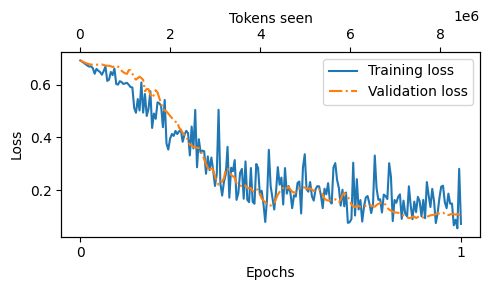

In [34]:
epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

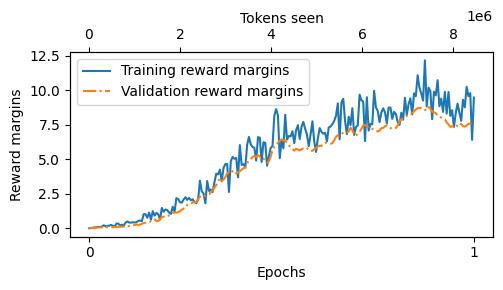

In [35]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    label="reward margins"
)